In [35]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, ZeroPadding2D
from tensorflow.keras.optimizers import RMSprop
print(os.listdir("input/data/")) # ../input

['.DS_Store', 'test', 'train']


In [4]:
df_labels = pd.read_csv("input/labels.csv")

In [5]:
df_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [6]:
df_train = df_labels
df_train['filename'] = df_labels.id.map(lambda id: f'input/data/train/{id}.jpg')

# RestNet50 Transfer learning

In [42]:
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [36]:
model = tf.keras.applications.ResNet50(weights='imagenet')

In [54]:
# df_labels.loc[df_labels['breed'] == 'scottish_deerhound', ['id', 'breed']].values
img_id = df_labels.id[0]
img = image.load_img('input/data/train/'+img_id+'.jpg', target_size=(224, 224))
img = image.img_to_array(img)

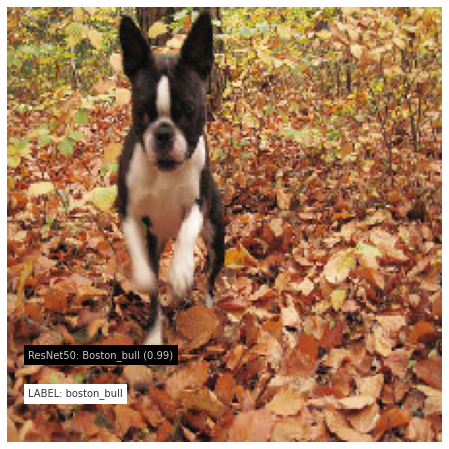

In [69]:
x = preprocess_input(np.expand_dims(img.copy(), axis=0))
preds = model.predict(x)
_, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img / 255.)
ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
ax.text(10, 200, 'LABEL: %s' % df_labels.breed[0], color='k', backgroundcolor='w', alpha=0.8)
ax.axis('off')
plt.show()

## Extract VGG16 bottleneck features

In [75]:
from tqdm import tqdm

In [78]:
INPUT_SIZE = 224
POOLING = 'avg'

x_train = np.zeros((len(df_labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(df_labels['id'])):
    img = image.load_img('input/data/train/'+img_id+'.jpg', target_size=(INPUT_SIZE, INPUT_SIZE))
    img = image.img_to_array(img)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

10222it [01:39, 102.41it/s]Train Images shape: (10222, 224, 224, 3) size: 1,538,697,216



In [81]:
vgg_bottleneck = tf.keras.applications.VGG16(weights='imagenet', include_top=False, pooling=POOLING)

58892288/58889256 [==============================] - 7s 0us/step


In [93]:
xtr = x_train[:8177]
xv = x_train[8177:]

In [94]:
train_vgg_bf = vgg_bottleneck.predict(xtr, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(xv, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

64/64 [==============================] - 161s 3s/step
VGG train bottleneck features shape: (8177, 512) size: 4,186,624
VGG valid bottleneck features shape: (2045, 512) size: 1,047,040


# LogReg on VGG bottleneck features

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

SEED = 37
np.random.seed(seed=SEED)

NUM_CLASSES = 120

logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, ytr)
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

In [126]:
print('Validation VGG LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score(yv, valid_preds)))

Validation VGG LogLoss 2.130593753235082
Validation VGG Accuracy 0.6899755501222494


# Extract Xception bottleneck features

In [128]:
from tensorflow.keras.applications import xception
from tensorflow.keras.applications import inception_v3

In [129]:
x_train = np.zeros((len(df_labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(df_labels['id'])):
    img = image.load_img('input/data/train/'+img_id+'.jpg', target_size=(INPUT_SIZE, INPUT_SIZE))
    img = image.img_to_array(img)
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

10222it [00:36, 278.09it/s]Train Images shape: (10222, 224, 224, 3) size: 1,538,697,216



In [131]:
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
train_x_bf = xception_bottleneck.predict(xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

64/64 [==============================] - 77s 1s/step
Xception train bottleneck features shape: (8177, 2048) size: 16,746,496
Xception valid bottleneck features shape: (2045, 2048) size: 4,188,160


# Extract Inception bottleneck features

In [134]:
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling='avg')
train_i_bf = inception_bottleneck.predict(xtr, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(xv, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))

64/64 [==============================] - 34s 531ms/step
InceptionV3 train bottleneck features shape: (8177, 2048) size: 16,746,496
InceptionV3 valid bottleneck features shape: (2045, 2048) size: 4,188,160


# LogReg on Inception bottleneck features

In [146]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_i_bf, ytr)
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)

In [147]:
print('Validation Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Inception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

Validation Inception LogLoss 8.434675033191406
Validation Inception Accuracy 0.038141809290953545


# LogReg on all bottleneck features

In [149]:
X = np.hstack([train_x_bf, train_i_bf])
V = np.hstack([valid_x_bf, valid_i_bf])
print('Full train bottleneck features shape: {} size: {:,}'.format(X.shape, X.size))
print('Full valid bottleneck features shape: {} size: {:,}'.format(V.shape, V.size))
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(X, (ytr))
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)
print('Validation Xception + Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception + Inception Accuracy {}'.format(accuracy_score(yv, valid_preds)))

Full train bottleneck features shape: (8177, 4096) size: 33,492,992
Full valid bottleneck features shape: (2045, 4096) size: 8,376,320
Validation Xception + Inception LogLoss 12.154861115334185
Validation Xception + Inception Accuracy 0.05525672371638142


# Check errors

000bec180eb18c7604dcecc8fe0dba07 entlebucher entlebucher


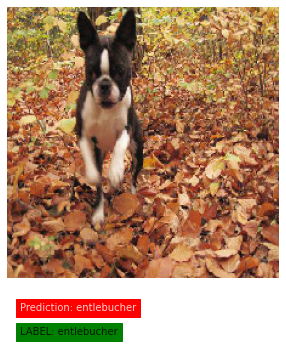

In [262]:
valid_breeds = yv
error_idx = (valid_breeds != valid_preds)
df_labels.loc[xv.shape[:0], 'id'].values[error_idx.shape[:0]]
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)


[df_labels.breed.values[int(b)] for b in valid_preds.shape[:]]
[df_labels.breed.values[int(b)] for b in valid_breeds.shape[:]]


for img_id, breed, pred in zip(
    df_labels.loc[xv.shape[:0], 'id'].values[error_idx.shape[:0]], 
    [df_labels.breed.values[int(b)] for b in valid_preds.shape[:]], 
    [df_labels.breed.values[int(b)] for b in valid_breeds.shape[:]]):
    print(img_id, breed, pred)

    fig, ax = plt.subplots(figsize=(5,5))
    img = image.load_img('input/data/train/'+img_id+'.jpg', target_size=(INPUT_SIZE, INPUT_SIZE))
    img = image.img_to_array(img)
    ax.imshow(img / 255.)
    ax.text(10, 250, 'Prediction: %s' % pred, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'LABEL: %s' % breed, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()    